In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import time
from sklearn.cluster import DBSCAN,KMeans,k_means
from sklearn.preprocessing import scale
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# DS数模团队原创思路，如果您买的是盗版，请务必在公众号：DS数模，输入：mathorcup。获取D题答疑群群号
# 如果本代码出现问题或其他优化思路，会在答疑群进行更新！并且，大家有问题在答疑群中也可以问DS C君

In [2]:
df_1 = pd.read_csv('附件1 弱覆盖栅格数据(筛选).csv')
df_2 = pd.read_csv('附件2 现网站址坐标(筛选).csv')

# 图

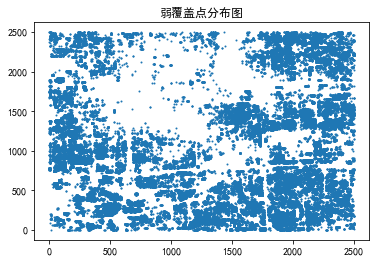

In [3]:
plt.scatter(df_1['x'],df_1['y'],s=1)
plt.title('弱覆盖点分布图')
plt.savefig('弱覆盖点分布图')
plt.show()

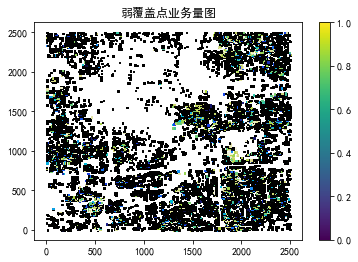

In [4]:
cf=plt.scatter(df_1['x'],df_1['y'],c=np.array([1,1,1,2])-cm.CMRmap(df_1['traffic']),s=2,marker='s')
plt.title('弱覆盖点业务量图')
plt.colorbar(cf)
plt.savefig('弱覆盖点业务量图')
plt.show()

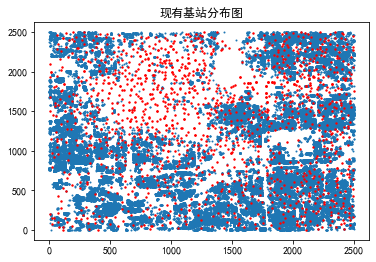

In [5]:
plt.scatter(df_1['x'],df_1['y'],s=1)
plt.scatter(df_2['x'],df_2['y'],c='r',s=2)
plt.title('现有基站分布图')
plt.savefig('现有基站分布图')
plt.show()

In [6]:
mat = np.zeros([2500,2500])
for i in df_1.index:
    mat[df_1['x'][i]][df_1['y'][i]]=df_1['traffic'][i]

# 根据半径求收益

In [7]:
def circle(mat,x,y,r):
    ans = 0
    for i in range(r*2):
        for j in range(r*2):
            if (i-r)**2+(j-r)**2<=r**2:
                if i+x>=2500 or j+y>=2500:
                    continue
                ans+=mat[i+x][j+y]
    return ans

计算30*30每个区块的收益  
* （后续称为30区块均值或类似的说法）

In [8]:
mat_30 = np.zeros([84,84])
for i in range(83):
    for j in range(83):
        mat_30[i][j] = mat[i*30:(i+1)*30,j*30:(j+1)*30].sum()

计算10*10每个区块的收益

In [9]:
mat_10 = np.zeros([250,250])
for i in range(250):
    for j in range(250):
        mat_10[i][j] = np.sum(mat[i*10:(i+1)*10,j*10:(j+1)*10])

得出区块平均收益

In [10]:
base_10,base_30=mat_10.sum()/6250000*100,mat_30.sum()/6250000*900

In [11]:
np.sum(mat_10>base_10)

7168

# 计算每一个点的微基站收益  
（每隔一个点进行计算，这里计算时间较长）  
导入方式：get_mat10=np.load('get_mat10.npy')

In [12]:
get_mat10 = np.zeros([2500,2500])
for i in range(0,2500,2):
    for j in range(0,2500,2):
        if mat[i][j]:
            get_mat10[i][j]=circle(mat,i,j,10)

In [13]:
# np.save('get_mat10',get_mat10)

# 计算每一个点的宏基站收益  
（每隔一个点进行计算，这里计算时间较长）  
get_mat30=np.load('get_mat30.npy')

In [14]:
get_mat30 = np.zeros([2500,2500])
for i in range(0,2500,2):
    for j in range(0,2500,2):
        if mat[i][j]:
            get_mat30[i][j]=circle(mat,i,j,30)

In [15]:
# np.save('get_mat30',get_mat30)

In [16]:
def get_max(mat,x,y):
    max_x,max_y,max_ans,max_r=0,0,0,0
    for i in range(x,x+10):
        for j in range(y,y+10):
            big=circle(mat,i,j,30)
            small = circle(mat,i,j,10)
            if big/base_30>big/base_10:
                ans,r=big,1
            else:
                ans,r=small,0
            if ans>max_ans:
                max_ans,max_r,max_x,max_y=ans,r,i,y
    return max_x,max_y,max_ans,max_r

在10倍平均收益的10*10的区块里进行遍历，  
宏，微判断标准  
当前点宏的收益/30区块平均收益与当前点微的收益/10区块平均收益的大小进行比较，当前者大则选择宏，否则选择微

In [17]:
df=[]
t=time.time()
n=0
for i in range(0, 250):
    for j in range(0, 250):
        if mat_10[i][j]>base_10*10:   #  此处*10可以改为1-10都可
            for k in range(i*10,(i+1)*10,2):
                for m in range(j*10,(j+1)*10,2):
                    big=circle(mat,k,m,30)
                    small = circle(mat,k,m,10)
                    if big/base_30>small/base_10:
                        ans,r=big,1
                    else:
                        ans,r=small,0
                    df.append([k,m,ans,r])

In [18]:
df_data = pd.DataFrame(df,columns=['x','y','traffic','label'])
df_data

,x,y,traffic,label
0,0,990,6701.505311,1
1,0,992,6188.654546,1
2,0,994,5983.917003,1
3,0,996,5944.303432,1
4,0,998,5867.916583,1
...,...,...,...,...
32995,2498,2390,0.000000,0
32996,2498,2392,0.000000,0
32997,2498,2394,0.000000,0
32998,2498,2396,0.000000,0


In [19]:
df_data['label'].sum()

11898

In [20]:
df_data.to_excel('较好的点.xlsx')

# 计算现有基站

In [21]:
ans=0
for i in df_2.index:
    ans+=circle(mat,df_2['x'][i],df_2['y'][i],10)
ans,ans/np.sum(mat)*100

(485181.630427, 6.8759326516462185)

In [22]:
ans=0
for i in df_2.index:
    ans+=circle(mat,df_2['x'][i],df_2['y'][i],30)
ans,ans/np.sum(mat)*100

(4896532.988109999, 69.3930456995611)

In [23]:
count = 0
df_2['label']=0
for i in df_2.index:
    big = circle(mat,df_2['x'][i],df_2['y'][i],30)
    small = circle(mat,df_2['x'][i],df_2['y'][i],10)
    if big/base_30 > small/base_10:
        df_2['label'][i]=1
    else:
        count+=1
count

648

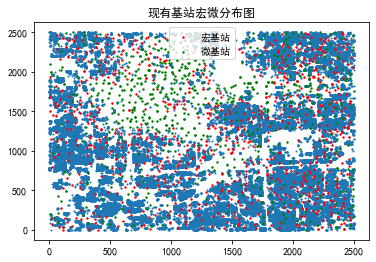

In [24]:
plt.scatter(df_1['x'],df_1['y'],s=1)
plt.scatter(df_2[df_2['label']==1]['x'],df_2[df_2['label']==1]['y'],c='r',s=2,label='宏基站')
plt.scatter(df_2[df_2['label']==0]['x'],df_2[df_2['label']==0]['y'],c='g',s=2,label='微基站')
plt.title('现有基站宏微分布图')
plt.legend()
plt.savefig('现有基站宏微分布图')
plt.show()

按照上述标准对现有基站进行宏微挑选

In [25]:
ans=0
df_2['traffic']=0
for i in df_2.index:
    c=circle(mat,df_2['x'][i],df_2['y'][i],df_2['label'][i]*30+(1-df_2['label'][i])*10)
    df_2['traffic'][i]=c
    ans+=c
ans/np.sum(mat)*100,np.sum(df_2['label'])/1474*100

(64.42481571462562, 56.03799185888738)

剔除在现有基站附近的基站

In [26]:
# DS数模团队原创思路，如果您买的是盗版，请务必在公众号：DS数模，输入：mathorcup。获取D题答疑群群号
# 如果本代码出现问题或其他优化思路，会在答疑群进行更新！并且，大家有问题在答疑群中也可以问DS C君
use = []
for i in df_data.index:
    data=np.array(df_data.values[i,:2])
    if df_data.values[i,3]:
        if (np.linalg.norm(df_2[['x','y']].values-data,axis=1)<=40).any():
            continue
        if (np.linalg.norm(df_2[df_2['label']==1][['x','y']].values-data,axis=1)<=60).any():
            continue
    else:
        if (np.linalg.norm(df_2[['x','y']].values-data,axis=1)<=20).any():
            continue
        if (np.linalg.norm(df_2[df_2['label']==1][['x','y']].values-data,axis=1)<=40).any():
            continue
    use.append(i)
use

[25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 205,
 206,
 207,
 210,
 211,
 212,
 213,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 295,
 296,
 29

对新建的基站进行聚类，方便选择同一区域内的收益最大的基站

In [27]:
db=DBSCAN(10,min_samples=1,n_jobs=4)
db.fit(df_data.values[:,:2])
db.labels_
labels=np.unique(db.labels_)

这里使用DBSCAN聚类算法进行聚类，聚类标准为类簇的最大距离为10。但是同一类簇内是可能存在与相同类簇点的距离大于10且与不同类簇的点的距离大于10，如下图所示：
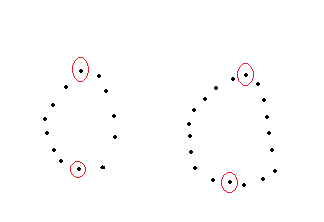
（在挑选过程中，我们并没有选择这些点，这里是可以提升的地方）  
对于同一类簇选择收益最大的一个点建立基站

In [28]:
uses = []
for label in labels:
    max_ = 0
    flag=0
    for i in use:
        if label == db.labels_[i]:
            if max_ < df_data.values[i,2]:
                max_ = df_data.values[i,2]
                max_i=i
                flag=1
    if flag:
        uses.append(max_i)

In [29]:
for i in uses:
    print(df_data.values[i,:])

[8.00000000e+00 1.35000000e+03 5.23797099e+03 1.00000000e+00]
[   0.       1570.       1817.511779    0.      ]
[8.00000000e+00 1.74600000e+03 8.53141134e+03 1.00000000e+00]
[    0.        1810.       11266.350893     0.      ]
[   0.       2450.       5029.342625    0.      ]
[   18.        2190.       11071.707431     0.      ]
[  20.       2466.       4317.511314    0.      ]
[  20.       2480.       2443.527909    0.      ]
[3.80000000e+01 5.80000000e+02 1.34084765e+04 1.00000000e+00]
[3.80000000e+01 7.42000000e+02 2.25949057e+04 1.00000000e+00]
[  30.       1010.       4112.590669    0.      ]
[  30.       1744.       7691.315226    0.      ]
[5.8000000e+01 1.3800000e+03 3.6437285e+03 1.0000000e+00]
[  46.      1668.       197.84713    0.     ]
[   52.         532.       13093.363762     0.      ]
[  54.        760.       4036.199364    0.      ]
[  68.       1880.       5138.679888    0.      ]
[5.20000000e+01 2.20800000e+03 5.36839515e+03 1.00000000e+00]
[6.40000000e+01 5.820000

[1648.       2394.        170.024096    0.      ]
[1658.        198.       1587.340137    0.      ]
[1660.       464.      1391.82988    0.     ]
[1660.        210.       2453.248357    0.      ]
[1660.        260.       2306.524308    0.      ]
[1660.        290.       1160.407999    0.      ]
[1668.       1178.       5586.654613    0.      ]
[1690.        234.       3744.487813    0.      ]
[1688.       1130.        626.497714    0.      ]
[1.69000000e+03 2.68000000e+02 8.52958237e+03 1.00000000e+00]
[1.69800000e+03 2.96000000e+02 1.09260684e+04 1.00000000e+00]
[1690.        460.       3385.200365    0.      ]
[1690.        520.       3481.730315    0.      ]
[1700.        900.       2832.252384    0.      ]
[1.72000000e+03 2.90000000e+02 1.15869954e+04 1.00000000e+00]
[1720.        316.       3501.711436    0.      ]
[1740.        462.       4073.400554    0.      ]
[1740.       2480.        722.968032    0.      ]
[1760.        108.        149.156907    0.      ]
[1792.        430.

In [30]:
df_data.values[uses,:]

array([[8.00000000e+00, 1.35000000e+03, 5.23797099e+03, 1.00000000e+00],
       [0.00000000e+00, 1.57000000e+03, 1.81751178e+03, 0.00000000e+00],
       [8.00000000e+00, 1.74600000e+03, 8.53141134e+03, 1.00000000e+00],
       ...,
       [2.48000000e+03, 1.81000000e+03, 1.21531755e+03, 0.00000000e+00],
       [2.49000000e+03, 1.48000000e+03, 1.10749564e+03, 0.00000000e+00],
       [2.49000000e+03, 2.39000000e+03, 4.66683267e+03, 0.00000000e+00]])

新建基站收益

In [31]:
np.sum(df_data.values[uses,2])/np.sum(mat)*100

24.226368694512484

总收益

In [32]:
np.sum(df_data.values[uses,2])/np.sum(mat)*100+df_2.loc[:,'traffic'].sum()/np.sum(mat)*100

88.6438965551332

In [33]:
df_ans = df_2.copy()
df_ans.shape

(1474, 5)

In [34]:
df_data.iloc[uses,:].shape

(362, 4)

In [35]:
df_ans=df_ans.append(df_data.iloc[uses,:],ignore_index=True)
df_ans.head()

,id,x,y,label,traffic
0,1.0,818,2020,0,0.0
1,4.0,713,2013,0,0.0
2,33.0,2305,291,1,3438.0
3,35.0,700,1953,0,0.0
4,36.0,949,2293,0,0.0


In [36]:
df_ans['traffic'].sum()/mat.sum()*100

88.64389655513321

In [37]:
df_ans.to_excel('第一题结果表.xlsx')

本结果具有较大的提升空间，为了较快的得出结果，在迭代过程中选择了10倍10区块均值，如果设置较小的值，最终结果会更好。至少提升2%是可以的

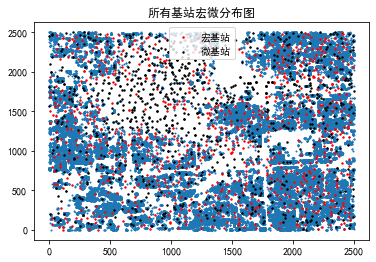

In [38]:
plt.scatter(df_1['x'],df_1['y'],s=1)
plt.scatter(df_ans[df_ans['label']==1]['x'],df_ans[df_ans['label']==1]['y'],c='red',s=2,label='宏基站')
plt.scatter(df_ans[df_ans['label']==0]['x'],df_ans[df_ans['label']==0]['y'],c='black',s=2,label='微基站')
plt.title('所有基站宏微分布图')
plt.legend()
plt.savefig('所有基站宏微分布图')
plt.show()